In [9]:
# imports with aliases
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
from PIL import Image
from pathlib import Path

# from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

# TensorFlow imports
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

# Configuration
plt.style.use('ggplot')
%matplotlib inline

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Print versions
print(f"TensorFlow Version: {tf.__version__}")
print(f"OpenCV Version: {cv2.__version__}")

# Define constants
IMG_SIZE = (48, 48)
BATCH_SIZE = 64
INPUT_SHAPE = (*IMG_SIZE, 1)  # Grayscale single channel


TensorFlow Version: 2.13.0
OpenCV Version: 4.8.0


In [10]:
# Define base directory and paths
BASE_DIR = '../../data/raw/fer2013/'
TRAIN_DIR = os.path.join(BASE_DIR, 'train')
TEST_DIR = os.path.join(BASE_DIR, 'test')

# Emotion Map(Update)
EMOTION_MAP = {
    'angry': 'angry',
    'disgust': 'stressed',
    'fear': 'stressed',
    'happy': 'happy',
    'sad': 'sad',
    'surprise': 'happy',
    'neutral': 'neutral'
}

CLASS_NAMES = sorted(list(set(EMOTION_MAP.values())))
NUM_CLASSES = len(CLASS_NAMES)

print(f"Classes after merging: {CLASS_NAMES}")
print(f"Number of classes: {NUM_CLASSES}")

Classes after merging: ['angry', 'happy', 'neutral', 'sad', 'stressed']
Number of classes: 5


In [3]:
def preprocess_image(img_path):
    """
    Basic preprocessing for FER2013 images:
    - Load as grayscale
    - Normalize to [0, 1]
    - Add channel dimension
    """
    # Load image (already grayscale 48x48)
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    # Normalize to [0, 1]
    img_normalized = img.astype(np.float32) / 255.0
    
    # Add channel dimension for CNN: (48, 48) → (48, 48, 1)
    img_final = np.expand_dims(img_normalized, axis=-1)
    
    return img_final

def load_and_preprocess_data(directory, emotion_map):
    """
    Load images and labels from directory, apply preprocessing and class mapping
    """
    images = []
    labels = []
    class_counts = {cls: 0 for cls in set(emotion_map.values())}
    
    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)
        if not os.path.isdir(emotion_path):
            continue
            
        # Get mapped emotion class
        mapped_emotion = emotion_map.get(emotion.lower(), None)
        if mapped_emotion is None:
            continue
            
        # Process each image in the emotion directory
        for img_file in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_file)
            
            # Preprocess image
            img = preprocess_image(img_path)
            images.append(img)
            labels.append(mapped_emotion)
            class_counts[mapped_emotion] += 1
    
    # Convert to numpy arrays
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels, class_counts

<Figure size 1200x600 with 0 Axes>

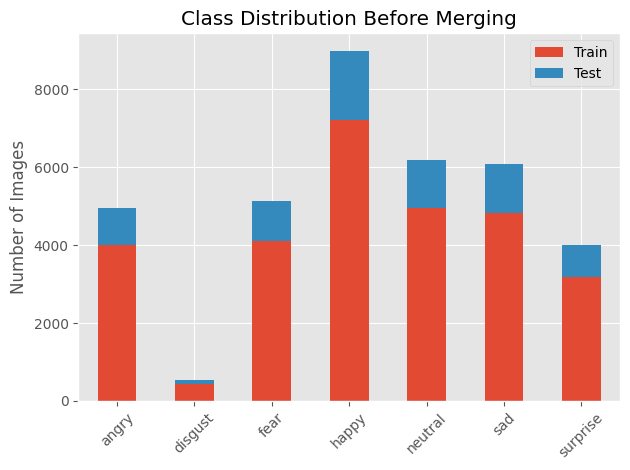

In [4]:
# Function to count images in each class
def count_images(directory):
    counts = {}
    for emotion in os.listdir(directory):
        emotion_path = os.path.join(directory, emotion)
        if os.path.isdir(emotion_path):
            counts[emotion] = len(os.listdir(emotion_path))
    return counts

# Count images in train and test sets
train_counts = count_images(TRAIN_DIR)
test_counts = count_images(TEST_DIR)

# Create DataFrame for visualization
count_df = pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts
}).fillna(0)

# Plot class distribution
plt.figure(figsize=(12, 6))
count_df.plot(kind='bar', stacked=True)
plt.title('Class Distribution Before Merging')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Training data shape: (28709, 48, 48, 1)
Training labels shape: (28709,)
Test data shape: (7178, 48, 48, 1)
Test labels shape: (7178,)


<Figure size 1200x600 with 0 Axes>

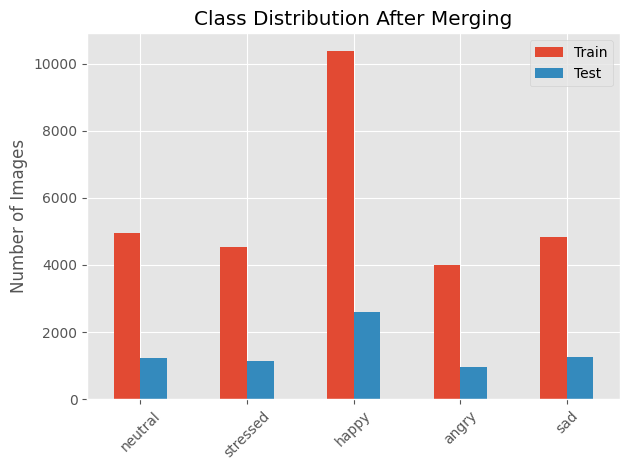

In [5]:
# Load and preprocess training data
X_train, y_train, train_counts = load_and_preprocess_data(TRAIN_DIR, EMOTION_MAP)

# Load and preprocess test data
X_test, y_test, test_counts = load_and_preprocess_data(TEST_DIR, EMOTION_MAP)

# Print dataset shapes
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test data shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

# Plot class distribution after merging
plt.figure(figsize=(12, 6))
pd.DataFrame({
    'Train': train_counts,
    'Test': test_counts
}).plot(kind='bar')
plt.title('Class Distribution After Merging')
plt.ylabel('Number of Images')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# Convert string labels to numerical labels
label_to_index = {emotion: idx for idx, emotion in enumerate(CLASS_NAMES)}
index_to_label = {idx: emotion for emotion, idx in label_to_index.items()}

# Convert string labels to numerical
y_train_num = np.array([label_to_index[label] for label in y_train])
y_test_num = np.array([label_to_index[label] for label in y_test])

# One-hot encode labels
y_train_encoded = to_categorical(y_train_num, num_classes=NUM_CLASSES)
y_test_encoded = to_categorical(y_test_num, num_classes=NUM_CLASSES)

# Calculate class weights for handling imbalance
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train_num),
    y=y_train_num
)
class_weights = dict(enumerate(class_weights))

print("\nClass weights for handling imbalance:")
for idx, weight in class_weights.items():
    print(f"{index_to_label[idx]}: {weight:.2f}")


Class weights for handling imbalance:
angry: 1.44
happy: 0.55
neutral: 1.16
sad: 1.19
stressed: 1.27



Augmented training samples:


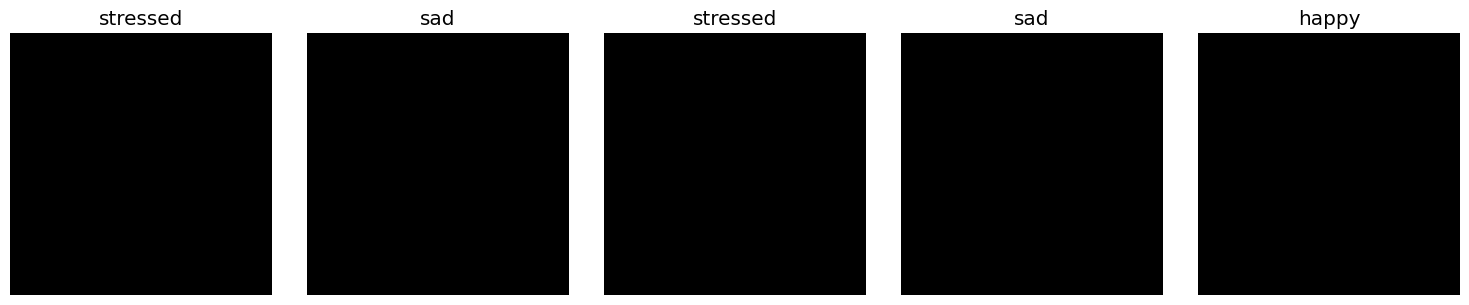

In [7]:
# Create data augmentation generator
train_datagen = ImageDataGenerator(
    rotation_range=15,          # ±15 degrees
    width_shift_range=0.1,      # ±10% horizontal shift
    height_shift_range=0.1,     # ±10% vertical shift
    brightness_range=[0.9, 1.1], # ±10% brightness
    zoom_range=0.1,             # ±10% zoom
    horizontal_flip=True,       # 50% chance (be careful with asymmetric emotions)
    fill_mode='nearest'         # Fill missing pixels
)

# Validation/test generator (only normalization)
test_datagen = ImageDataGenerator()

# Create data generators
train_generator = train_datagen.flow(
    X_train,
    y_train_encoded,
    batch_size=BATCH_SIZE,
    shuffle=True
)

validation_generator = test_datagen.flow(
    X_test,
    y_test_encoded,
    batch_size=BATCH_SIZE,
    shuffle=False
)

# Visualize augmented samples
def plot_augmented_samples(generator, n_samples=5):
    plt.figure(figsize=(15, 3))
    for i in range(n_samples):
        # Get a batch of augmented images
        for X_batch, y_batch in generator:
            # Convert grayscale to RGB for display
            img = np.squeeze(X_batch[0])
            label = index_to_label[np.argmax(y_batch[0])]
            
            plt.subplot(1, n_samples, i+1)
            plt.imshow(img, cmap='gray')
            plt.title(label)
            plt.axis('off')
            break  # Only show one image per batch
    plt.tight_layout()
    plt.show()

print("\nAugmented training samples:")
plot_augmented_samples(train_generator)

In [8]:
# Create directory for processed data
PROCESSED_DIR = '../../data/processed/fc211042_heshani'
os.makedirs(PROCESSED_DIR, exist_ok=True)

# make sure X_train, y_train_encoded, index_to_label already exist
train_out = Path(PROCESSED_DIR) / "train"
test_out  = Path(PROCESSED_DIR) / "test"
train_out.mkdir(parents=True, exist_ok=True)
test_out.mkdir(parents=True,  exist_ok=True)

def save_images(array, labels, root_dir):
    for idx, (img, label_vec) in enumerate(zip(array, labels)):
        class_name = index_to_label[int(np.argmax(label_vec))]
        class_dir  = root_dir / class_name
        class_dir.mkdir(exist_ok=True)
        img_uint8  = (img.squeeze() * 255).astype("uint8")      # back to 0‑255
        file_path  = class_dir / f"{idx:06d}.jpg"
        cv2.imwrite(str(file_path), img_uint8)

# save train and test sets
save_images(X_train, y_train_encoded, train_out)
save_images(X_test,  y_test_encoded,  test_out)

print("Preprocessed data saved successfully!")

Preprocessed data saved successfully!
